# Decision Trees

### Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
import pickle
from sklearn.model_selection import GridSearchCV
import inspect

### Data Analysis

In [9]:
df = pd.read_csv('Data/voice.csv')

In [10]:
x = df.iloc[:,:-1]
y = df.label

### Methodology

Test Train Split


In [11]:
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

Model Creation

In [9]:
DTmodel = DecisionTreeClassifier(random_state = 1)
path = DTmodel.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

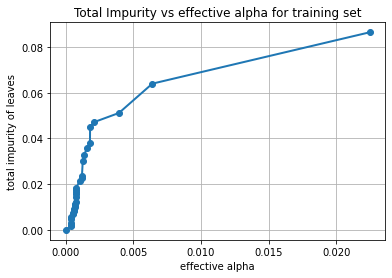

In [10]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", linestyle='-', linewidth=2)
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
ax.grid()

In [11]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

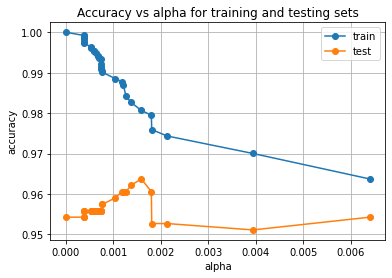

In [30]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", )
ax.plot(ccp_alphas, test_scores, marker="o", label="test", )
ax.legend()
ax.grid()
plt.show()

In [16]:
ind = np.argpartition(test_scores, -4)[-4:]
for i in ind:
    print(ccp_alphas[i])

0.0011873606668605218
0.0018043256401583164
0.0013766062967446955
0.001593281685250423


In [19]:
param_grid = {
    'ccp_alpha' : [0.0011873606668605218, 0.0018043256401583164, 0.0013766062967446955, 0.001593281685250423],
    'criterion' : ['gini','entropy'],
    'max_depth' : [50, 100, 150, 200]
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3)

grid.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=50;, score=0.961 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=50;, score=0.978 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=50;, score=0.970 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=50;, score=0.966 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=50;, score=0.968 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=100;, score=0.963 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=100;, score=0.980 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth=100;, score=0.970 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0011873606668605218, criterion=gini, max_depth

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0011873606668605218,
                                       0.0018043256401583164,
                                       0.0013766062967446955,
                                       0.001593281685250423],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [50, 100, 150, 200]},
             verbose=3)

In [5]:
print(f'Params: {grid.best_params_}')

NameError: name 'grid' is not defined

In [12]:
DTmodel = DecisionTreeClassifier(ccp_alpha = 0.0011873606668605218, criterion = 'gini', max_depth = 100)
DTmodel.fit(x_train, y_train)
pickle.dump(DTmodel, open("Models/DT.pickle", "wb"))
y_pred = DTmodel.predict(x_test)
y_pred = np.array(y_pred)

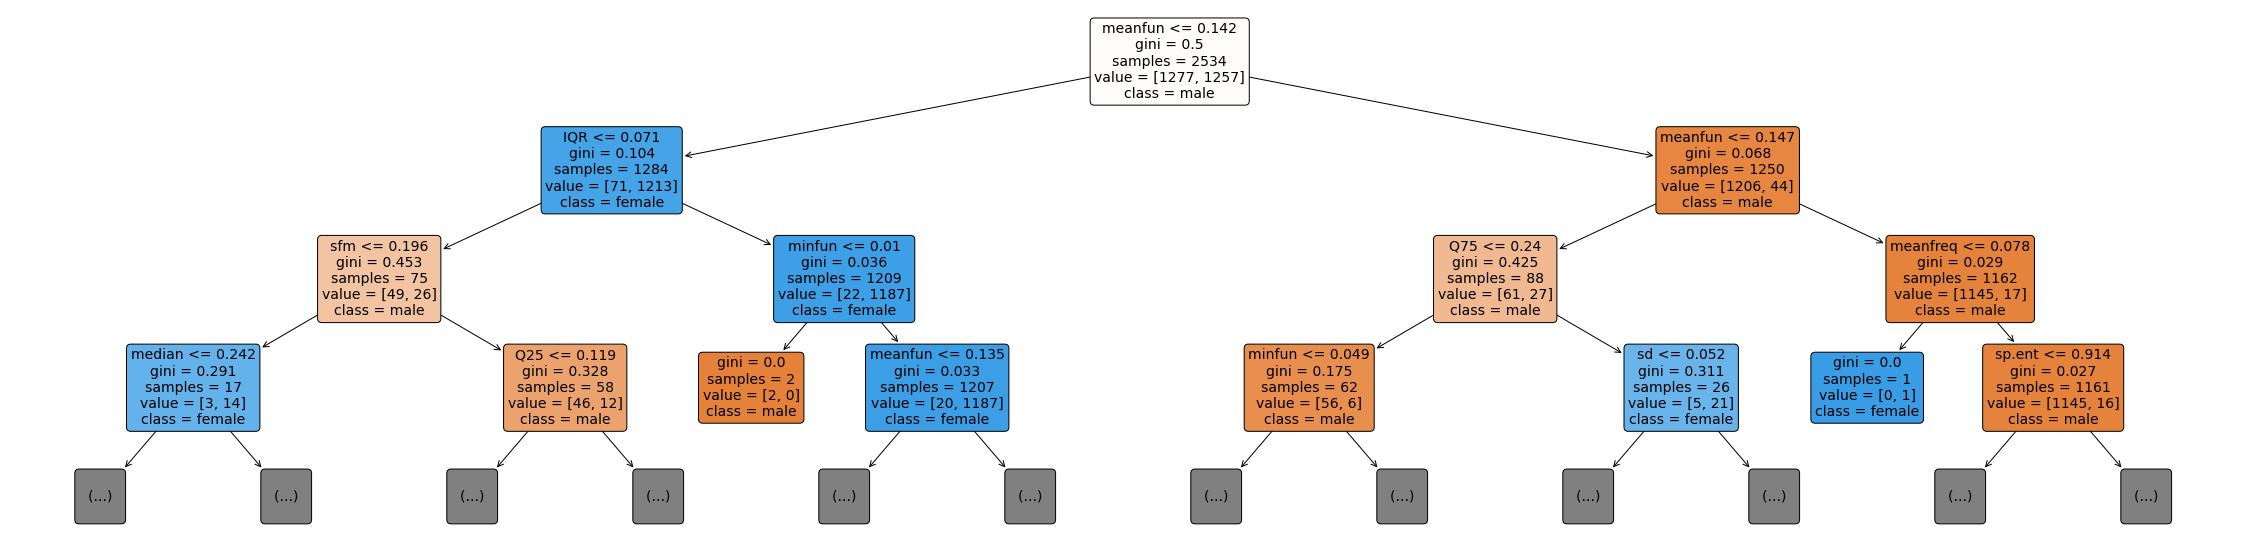

In [24]:
plt.figure(figsize=(40,10))
a = tree.plot_tree(DTmodel,
                   feature_names=x_test.columns,
                   class_names= ["male", "female"],
                   rounded = True,
                   filled = True,
                   max_depth= 3,
                   fontsize=14
)
plt.show()

### Evaluation

#### Accuracy

In [25]:
print("Decision Tree Accuracy score: ",accuracy_score(y_pred,y_test)*100,"%")

Decision Tree Accuracy score:  96.05678233438486 %


#### Confusion Matrix

In [15]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


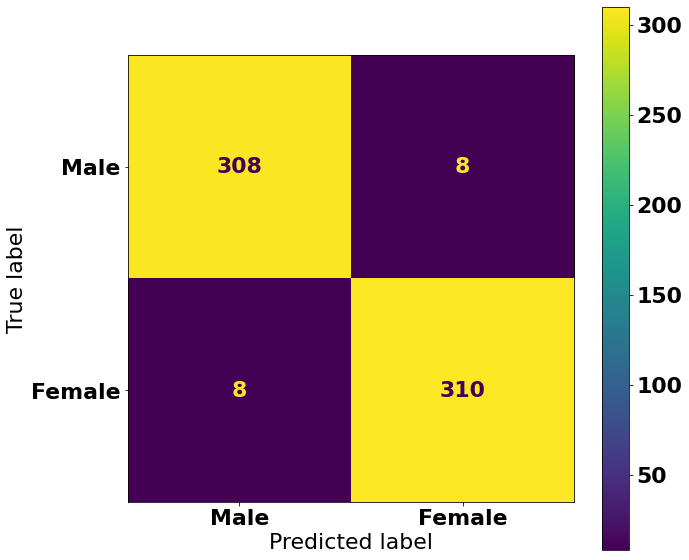

In [16]:
c = confusion_matrix(y_test, y_pred)
cp = ConfusionMatrixDisplay(c, display_labels=["Male", "Female"])
fig, ax = plt.subplots(figsize=(10,10))
cp.plot(ax = ax)

#### Classification Report

In [8]:
print("\t\t\tDecision Tree report:\n", classification_report(y_pred,y_test, digits=3))

			Decision Tree report:
               precision    recall  f1-score   support

      female      0.958     0.964     0.961       309
        male      0.966     0.960     0.963       325

    accuracy                          0.962       634
   macro avg      0.962     0.962     0.962       634
weighted avg      0.962     0.962     0.962       634



#### Feature Importance

In [28]:
importances = DTmodel.feature_importances_
importances_df = pd.DataFrame({'Feature_names':x_train.columns, 'Importance':importances})
importances_df = importances_df.sort_values(by=['Importance'], ascending=False)

Text(0, 0.5, 'Importance')

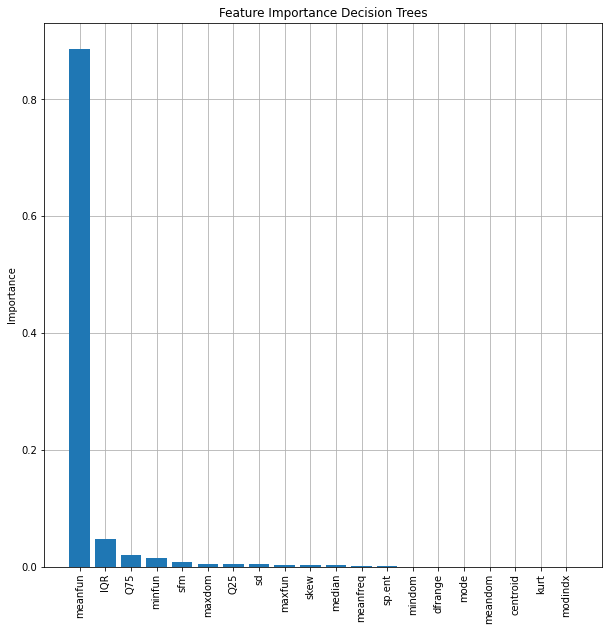

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(zorder=0)
ax.bar(importances_df['Feature_names'], importances_df['Importance'], zorder=3)
plt.xticks(rotation = 90) 
ax.set_title("Feature Importance Decision Trees")
ax.set_ylabel("Importance")